# Viscous stress tensor calculation with wall slip

The viscous stress tensor for a Newtonian fluid is usually expressed as a linear function of
the velocity gradient, i.e.,
$\tau_{ij} = \eta(u_{i,j} + u_{j,i}) + (\zeta - \frac{2}{3}\eta)u_{i,i}\delta_{ij}$.
Here, we seek an expression in terms of the gap-averaged densities of conserved
variables $\rho(x, y)$, $j_x(x, y)$, and $j_y(x, y)$.
Here, we use [Sympy](https://sympy.org) to derive the expressions for the stress tensor components.

We start with a common ansatz for the velocity profiles

$u(z) = a z (h - z) + \frac{U_{top} - U_{bot}}{h} z + U_{bot}$,

$v(z) = b z (h - z) + \frac{V_{top} - V_{bot}}{h} z + V_{bot}$,

$w(z) = cz^2(h - z)^2$,

for $z \in [0, h]$.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import sympy as sp

# Define Cartesian coordinates
x, y, z = sp.symbols("x y z")

# Define some constants
zeta, eta = sp.symbols("zeta eta")  # Viscosities

# The unknown parameters for the nonlinear part, that we need to find
a, b, c = sp.symbols("a b c")

# The gap height is a function of the lateral coordinates
h = sp.Function("h")

$U_{bot}$, $U_{top}$, $V_{bot}$, $V_{top}$ are the velocity of the outermost fluid
layers in contact with the the bottom and top wall, and in $x$ and $y$ direction, respectively.
In the case of the no slip boundary condition, these velocities are identical
with those of the wall. For the no slip boundary conditions, we have to account for the slip length $L_{slip}$

$U_{bot} = U_{bot,wall} + L_{slip, bot}\left(\frac{\partial u}{\partial z}\right)_{z=0}$,

$U_{top} = U_{top,wall} - L_{slip, top}\left(\frac{\partial u}{\partial z}\right)_{z=h}$,

$V_{bot} = V_{bot,wall} + L_{slip, top}\left(\frac{\partial v}{\partial z}\right)_{z=0}$,

$V_{top} = V_{top,wall} - L_{slip, top}\left(\frac{\partial v}{\partial z}\right)_{z=h}$.

Thus, wall velocities are constants...

In [2]:
Lsb, Lst = sp.symbols("Lsb Lst")
Utw, Ubw, Vtw, Vbw = sp.symbols("Utw Ubw Vtw Vbw")

...but the boundary layer velocities are functions (of x and y).

In [3]:
Ut, Ub, Vt, Vb = sp.symbols("Ut Ub Vt Vb")  # Velocities
# Ut = sp.Function('Ut')
# Ub = sp.Function('Ub')
# Vt = sp.Function('Vt')
# Vb = sp.Function('Vb')

In [4]:
# Velocity profiles
_u = (Ut - Ub) * z / h(x, y) + Ub + a * z * (h(x, y) - z)
_v = (Vt - Vb) * z / h(x, y) + Vb + b * z * (h(x, y) - z)
w = c * z**2 * (h(x, y) - z) ** 2

# Helper variables
__Ub = Ubw + Lsb * sp.diff(_u, z).subs(z, 0)
__Ut = Utw - Lst * sp.diff(_u, z).subs(z, h(x, y))
__Vb = Vbw + Lsb * sp.diff(_v, z).subs(z, 0)
__Vt = Vtw - Lst * sp.diff(_v, z).subs(z, h(x, y))

# Replace boundary layer velcoities
u = _u.subs({Ub: __Ub, Ut: __Ut})
v = _v.subs({Vb: __Vb, Vt: __Vt})

The unknown parameters can be found by using the definition of the
gap-averaged fluxes, e.g.

$j_x(x, y) = \frac{\rho(x, y)}{h(x,y)}\int_0^{h(x, y)} u(z) dz$,

where we assume that the density is constant across the gap.
Thus, we can solve the latter expression for $a$.

In [5]:
# Define continuum fields as functions
jx = sp.Function("jx")
jy = sp.Function("jy")
jz = sp.Function("jz")
rho = sp.Function("rho")

# Define equations
eq1 = sp.Eq(jx(x, y), rho(x, y) / h(x, y) * sp.integrate(u, (z, 0, h(x, y))))
eq2 = sp.Eq(jy(x, y), rho(x, y) / h(x, y) * sp.integrate(v, (z, 0, h(x, y))))
eq3 = sp.Eq(jz(x, y), rho(x, y) / h(x, y) * sp.integrate(w, (z, 0, h(x, y))))

# Solve for a, b, c
(_a,) = sp.solveset(eq1, a)
(_b,) = sp.solveset(eq2, b)
(_c,) = sp.solveset(eq3, c)

Furthermore, the boundary layer velocities need to be solved for using

$U_{bot} = u(0)$, $U_{top} = u(h)$,

$V_{bot} = v(0)$, $V_{top} = v(h)$.

In [6]:
eq4 = sp.Eq(Ub, u.subs(a, _a).subs(z, 0))
(_Ub,) = sp.solveset(eq4, Ub)

eq5 = sp.Eq(Ut, u.subs(a, _a).subs(z, h(x, y)).subs(Ub, _Ub))
(_Ut,) = sp.solveset(eq5, Ut)

eq6 = sp.Eq(Vb, v.subs(b, _b).subs(z, 0))
(_Vb,) = sp.solveset(eq6, Vb)

eq7 = sp.Eq(Vt, v.subs(b, _b).subs(z, h(x, y)).subs(Vb, _Vb))
(_Vt,) = sp.solveset(eq7, Vt)

It is important to realize that the solutions depend on the lateral coordinates.
Thus, before we differentiate, we need to substitute the solutions
into the expressions for the velocity profiles using ```subs```.

In [7]:
u_final = u.subs(a, _a).subs(Ub, _Ub).subs(Ut, _Ut)
v_final = v.subs(b, _b).subs(Vb, _Vb).subs(Vt, _Vt)

# Compute velocity gradients
du_dx = sp.diff(u_final, x)
du_dy = sp.diff(u_final, y)
du_dz = sp.diff(u_final, z)

dv_dx = sp.diff(v_final, x)
dv_dy = sp.diff(v_final, y)
dv_dz = sp.diff(v_final, z)

dw_dx = sp.diff(w.subs(c, _c), x)
dw_dy = sp.diff(w.subs(c, _c), y)
dw_dz = sp.diff(w.subs(c, _c), z)

# Symmetrize
Dxx = du_dx
Dyy = dv_dy
Dzz = dw_dz
Dxy = (du_dy + dv_dx) / 2
Dxz = (du_dz + dw_dx) / 2
Dyz = (dv_dz + dw_dy) / 2

# Trace
trD = Dxx + Dyy + Dzz

v1, v2 = sp.symbols("v1 v2")
# v1 = (zeta + sp.Rational(4, 3) * eta)
# v2 = (zeta - sp.Rational(2, 3) * eta)

# Viscous stress
Txx = v1 * Dxx + v2 * (Dyy + Dzz)
Tyy = v1 * Dyy + v2 * (Dxx + Dzz)
Tzz = v1 * Dzz + v2 * (Dxx + Dyy)
Txy = 2 * eta * Dxy
Txz = 2 * eta * Dxz
Tyz = 2 * eta * Dyz

Let's print the velolcity and stress profiles. First, we make some
simplifying assumptions and useful replacements.

In [8]:
H, Hx, Hy = sp.symbols("h[0] h[1] h[2]")
q0, q1, q2 = sp.symbols("q[0] q[1] q[2]")
dq0x, dq1x, dq2x = sp.symbols("dqx[0] dqx[1] dqx[2]")
dq0y, dq1y, dq2y = sp.symbols("dqy[0] dqy[1] dqy[2]")
U, V, Ls = sp.symbols("U V Ls")


_replace = {
    sp.Derivative(h(x, y), x): Hx,
    sp.Derivative(h(x, y), y): Hy,
    h(x, y): H,
    rho(x, y): q0,
    jx(x, y): q1,
    jy(x, y): q2,
    jz(x, y): 0,
    sp.Derivative(rho(x, y), x): dq0x,
    sp.Derivative(rho(x, y), y): dq0y,
    sp.Derivative(jx(x, y), x): dq1x,
    sp.Derivative(jx(x, y), y): dq1y,
    sp.Derivative(jy(x, y), x): dq2x,
    sp.Derivative(jy(x, y), y): dq2y,
    sp.Derivative(jz(x, y), x): 0,
    sp.Derivative(jz(x, y), y): 0,
    Ubw: U,
    Vbw: V,
    Vtw: 0,
    Utw: 0,
}

We may want to consider different combinations of slip/no-slip

In [9]:
write = False  # set to false when building the doc

replace_no_slip = deepcopy(_replace)
replace_no_slip["Lsb"] = 0
replace_no_slip["Lst"] = 0

replace_slip_bottom = deepcopy(_replace)
replace_slip_bottom["Lsb"] = Ls
replace_slip_bottom["Lst"] = 0

replace_slip_top = deepcopy(_replace)
replace_slip_top["Lsb"] = 0
replace_slip_top["Lst"] = Ls


replace_slip_both = deepcopy(_replace)
replace_slip_both["Lsb"] = Ls
replace_slip_both["Lst"] = Ls


# Velocity profiles
if write:
    print("\nVelocity profiles (no slip):")
    print("u = ", sp.simplify(u_final.subs(replace_no_slip)))
    print("v = ", sp.simplify(v_final.subs(replace_no_slip)))

    print("\nVelocity profiles (slip top):")
    print("u = ", sp.simplify(u_final.subs(replace_slip_top)))
    print("v = ", sp.simplify(v_final.subs(replace_slip_top)))

    print("\nVelocity profiles (slip bottom):")
    print("u = ", sp.simplify(u_final.subs(replace_slip_bottom)))
    print("v = ", sp.simplify(v_final.subs(replace_slip_bottom)))

    print("\nVelocity profiles (slip both):")
    print("u = ", sp.simplify(u_final.subs(replace_slip_both)))
    print("v = ", sp.simplify(v_final.subs(replace_slip_both)))

From now on, we consider only the case where both walls have the same slip properties

In [10]:
replace = replace_slip_both

if write:
    print("Stress profiles:")
    print("tau_xx = ", sp.simplify(Txx.subs(replace)))
    print("tau_yy = ", sp.simplify(Tyy.subs(replace)))
    print("tau_zz = ", sp.simplify(Tzz.subs(replace)))
    print("tau_xy = ", sp.simplify(Txy.subs(replace)))
    print("tau_xz = ", sp.simplify(Txz.subs(replace)))
    print("tau_yz = ", sp.simplify(Tyz.subs(replace)))

Solving the height-averaged balance equations, we need to evaluate the viscous stress at the walls...

In [11]:
if write:
    print("Stress bottom:")
    print("tau_xx(z=0) = ", sp.simplify(Txx.subs(replace).subs(z, 0)))
    print("tau_yy(z=0) = ", sp.simplify(Tyy.subs(replace).subs(z, 0)))
    print("tau_zz(z=0) = ", sp.simplify(Tzz.subs(replace).subs(z, 0)))
    print("tau_xy(z=0) = ", sp.simplify(Txy.subs(replace).subs(z, 0)))
    print("tau_xz(z=0) = ", sp.simplify(Txz.subs(replace).subs(z, 0)))
    print("tau_yz(z=0) = ", sp.simplify(Tyz.subs(replace).subs(z, 0)))

In [12]:
if write:
    print("Stress top:")
    print("tau_xx(z=h) = ", sp.simplify(Txx.subs(replace).subs(z, H)))
    print("tau_yy(z=h) = ", sp.simplify(Tyy.subs(replace).subs(z, H)))
    print("tau_zz(z=h) = ", sp.simplify(Tzz.subs(replace).subs(z, H)))
    print("tau_xy(z=h) = ", sp.simplify(Txy.subs(replace).subs(z, H)))
    print("tau_xz(z=h) = ", sp.simplify(Txz.subs(replace).subs(z, H)))
    print("tau_yz(z=h) = ", sp.simplify(Tyz.subs(replace).subs(z, H)))

...or averaged over the gap height

In [13]:
if write:
    # Average stress
    Txx_avg = sp.integrate(
        sp.simplify(Txx.subs(replace)), (z, 0, h(x, y))
    ) / h(x, y)
    Tyy_avg = sp.integrate(
        sp.simplify(Tyy.subs(replace)), (z, 0, h(x, y))
    ) / h(x, y)
    Txy_avg = sp.integrate(
        sp.simplify(Txy.subs(replace)), (z, 0, h(x, y))
    ) / h(x, y)

    print("Stress avg:")
    print("tau_xx_avg = ", sp.simplify(Txx_avg))
    print("tau_yy_avg = ", sp.simplify(Tyy_avg))
    print("tau_xy_avg = ", sp.simplify(Txy_avg))

These expressions are hardcoded in {py:mod}`hans.stress` or
can be directly copied into Python functions for plotting

In [14]:


def get_velocity_profiles(z, h, q, Ls=0.0, U=1.0, V=0.0, mode="both"):

    assert mode in ["both", "top", "bottom", "none"]

    if mode == "both":
        u = (
            12 * Ls**2 * h[0] * q[1]
            + 4 * Ls * U * h[0] ** 2 * q[0]
            - 12 * Ls * U * h[0] * q[0] * z
            + 6 * Ls * U * q[0] * z**2
            + 6 * Ls * h[0] ** 2 * q[1]
            + 12 * Ls * h[0] * q[1] * z
            - 12 * Ls * q[1] * z**2
            + U * h[0] ** 3 * q[0]
            - 4 * U * h[0] ** 2 * q[0] * z
            + 3 * U * h[0] * q[0] * z**2
            + 6 * h[0] ** 2 * q[1] * z
            - 6 * h[0] * q[1] * z**2
        ) / (h[0] * q[0] * (12 * Ls**2 + 8 * Ls * h[0] + h[0] ** 2))
        v = (
            12 * Ls**2 * h[0] * q[2]
            + 4 * Ls * V * h[0] ** 2 * q[0]
            - 12 * Ls * V * h[0] * q[0] * z
            + 6 * Ls * V * q[0] * z**2
            + 6 * Ls * h[0] ** 2 * q[2]
            + 12 * Ls * h[0] * q[2] * z
            - 12 * Ls * q[2] * z**2
            + V * h[0] ** 3 * q[0]
            - 4 * V * h[0] ** 2 * q[0] * z
            + 3 * V * h[0] * q[0] * z**2
            + 6 * h[0] ** 2 * q[2] * z
            - 6 * h[0] * q[2] * z**2
        ) / (h[0] * q[0] * (12 * Ls**2 + 8 * Ls * h[0] + h[0] ** 2))
    elif mode == "top":
        u = (
            4 * Ls * U * h[0] ** 2 * q[0]
            - 12 * Ls * U * h[0] * q[0] * z
            + 6 * Ls * U * q[0] * z**2
            + 12 * Ls * h[0] * q[1] * z
            - 6 * Ls * q[1] * z**2
            + U * h[0] ** 3 * q[0]
            - 4 * U * h[0] ** 2 * q[0] * z
            + 3 * U * h[0] * q[0] * z**2
            + 6 * h[0] ** 2 * q[1] * z
            - 6 * h[0] * q[1] * z**2
        ) / (h[0] ** 2 * q[0] * (4 * Ls + h[0]))
        v = (
            4 * Ls * V * h[0] ** 2 * q[0]
            - 12 * Ls * V * h[0] * q[0] * z
            + 6 * Ls * V * q[0] * z**2
            + 12 * Ls * h[0] * q[2] * z
            - 6 * Ls * q[2] * z**2
            + V * h[0] ** 3 * q[0]
            - 4 * V * h[0] ** 2 * q[0] * z
            + 3 * V * h[0] * q[0] * z**2
            + 6 * h[0] ** 2 * q[2] * z
            - 6 * h[0] * q[2] * z**2
        ) / (h[0] ** 2 * q[0] * (4 * Ls + h[0]))
    elif mode == "bottom":
        u = (
            6 * Ls * h[0] ** 2 * q[1]
            - 6 * Ls * q[1] * z**2
            + U * h[0] ** 3 * q[0]
            - 4 * U * h[0] ** 2 * q[0] * z
            + 3 * U * h[0] * q[0] * z**2
            + 6 * h[0] ** 2 * q[1] * z
            - 6 * h[0] * q[1] * z**2
        ) / (h[0] ** 2 * q[0] * (4 * Ls + h[0]))
        v = (
            6 * Ls * h[0] ** 2 * q[2]
            - 6 * Ls * q[2] * z**2
            + V * h[0] ** 3 * q[0]
            - 4 * V * h[0] ** 2 * q[0] * z
            + 3 * V * h[0] * q[0] * z**2
            + 6 * h[0] ** 2 * q[2] * z
            - 6 * h[0] * q[2] * z**2
        ) / (h[0] ** 2 * q[0] * (4 * Ls + h[0]))
    elif mode == "none":
        u = (
            U * h[0] ** 2 * q[0]
            - U * h[0] * q[0] * z
            - 3 * z * (h[0] - z) * (U * q[0] - 2 * q[1])
        ) / (h[0] ** 2 * q[0])
        v = (
            V * h[0] ** 2 * q[0]
            - V * h[0] * q[0] * z
            - 3 * z * (h[0] - z) * (V * q[0] - 2 * q[2])
        ) / (h[0] ** 2 * q[0])

    return u, v


def get_stress_profiles(
    z, h, q, dqx, dqy, U=1.0, V=0.0, eta=1.0, zeta=1.0, Ls=0, mode="both"
):

    v1 = zeta + 4 / 3 * eta
    v2 = zeta - 2 / 3 * eta

    if mode == "both":
        tau_xx = (
            2
            * (
                -72 * Ls**4 * dqx[0] * h[0] ** 2 * q[1] * v1
                + 72 * Ls**4 * dqx[1] * h[0] ** 2 * q[0] * v1
                - 72 * Ls**4 * dqy[0] * h[0] ** 2 * q[2] * v2
                + 72 * Ls**4 * dqy[2] * h[0] ** 2 * q[0] * v2
                + 24 * Ls**3 * U * h[0] ** 2 * h[1] * q[0] ** 2 * v1
                - 36 * Ls**3 * U * h[1] * q[0] ** 2 * v1 * z**2
                + 24 * Ls**3 * V * h[0] ** 2 * h[2] * q[0] ** 2 * v2
                - 36 * Ls**3 * V * h[2] * q[0] ** 2 * v2 * z**2
                - 84 * Ls**3 * dqx[0] * h[0] ** 3 * q[1] * v1
                - 72 * Ls**3 * dqx[0] * h[0] ** 2 * q[1] * v1 * z
                + 72 * Ls**3 * dqx[0] * h[0] * q[1] * v1 * z**2
                + 84 * Ls**3 * dqx[1] * h[0] ** 3 * q[0] * v1
                + 72 * Ls**3 * dqx[1] * h[0] ** 2 * q[0] * v1 * z
                - 72 * Ls**3 * dqx[1] * h[0] * q[0] * v1 * z**2
                - 84 * Ls**3 * dqy[0] * h[0] ** 3 * q[2] * v2
                - 72 * Ls**3 * dqy[0] * h[0] ** 2 * q[2] * v2 * z
                + 72 * Ls**3 * dqy[0] * h[0] * q[2] * v2 * z**2
                + 84 * Ls**3 * dqy[2] * h[0] ** 3 * q[0] * v2
                + 72 * Ls**3 * dqy[2] * h[0] ** 2 * q[0] * v2 * z
                - 72 * Ls**3 * dqy[2] * h[0] * q[0] * v2 * z**2
                - 12 * Ls**3 * h[0] ** 2 * h[1] * q[0] * q[1] * v1
                - 12 * Ls**3 * h[0] ** 2 * h[2] * q[0] * q[2] * v2
                + 72 * Ls**3 * h[1] * q[0] * q[1] * v1 * z**2
                + 72 * Ls**3 * h[2] * q[0] * q[2] * v2 * z**2
                + 12 * Ls**2 * U * h[0] ** 3 * h[1] * q[0] ** 2 * v1
                + 24 * Ls**2 * U * h[0] ** 2 * h[1] * q[0] ** 2 * v1 * z
                - 48 * Ls**2 * U * h[0] * h[1] * q[0] ** 2 * v1 * z**2
                + 12 * Ls**2 * V * h[0] ** 3 * h[2] * q[0] ** 2 * v2
                + 24 * Ls**2 * V * h[0] ** 2 * h[2] * q[0] ** 2 * v2 * z
                - 48 * Ls**2 * V * h[0] * h[2] * q[0] ** 2 * v2 * z**2
                - 30 * Ls**2 * dqx[0] * h[0] ** 4 * q[1] * v1
                - 84 * Ls**2 * dqx[0] * h[0] ** 3 * q[1] * v1 * z
                + 84 * Ls**2 * dqx[0] * h[0] ** 2 * q[1] * v1 * z**2
                + 30 * Ls**2 * dqx[1] * h[0] ** 4 * q[0] * v1
                + 84 * Ls**2 * dqx[1] * h[0] ** 3 * q[0] * v1 * z
                - 84 * Ls**2 * dqx[1] * h[0] ** 2 * q[0] * v1 * z**2
                - 30 * Ls**2 * dqy[0] * h[0] ** 4 * q[2] * v2
                - 84 * Ls**2 * dqy[0] * h[0] ** 3 * q[2] * v2 * z
                + 84 * Ls**2 * dqy[0] * h[0] ** 2 * q[2] * v2 * z**2
                + 30 * Ls**2 * dqy[2] * h[0] ** 4 * q[0] * v2
                + 84 * Ls**2 * dqy[2] * h[0] ** 3 * q[0] * v2 * z
                - 84 * Ls**2 * dqy[2] * h[0] ** 2 * q[0] * v2 * z**2
                - 12 * Ls**2 * h[0] ** 3 * h[1] * q[0] * q[1] * v1
                - 12 * Ls**2 * h[0] ** 3 * h[2] * q[0] * q[2] * v2
                - 12 * Ls**2 * h[0] ** 2 * h[1] * q[0] * q[1] * v1 * z
                - 12 * Ls**2 * h[0] ** 2 * h[2] * q[0] * q[2] * v2 * z
                + 96 * Ls**2 * h[0] * h[1] * q[0] * q[1] * v1 * z**2
                + 96 * Ls**2 * h[0] * h[2] * q[0] * q[2] * v2 * z**2
                + 2 * Ls * U * h[0] ** 4 * h[1] * q[0] ** 2 * v1
                + 12 * Ls * U * h[0] ** 3 * h[1] * q[0] ** 2 * v1 * z
                - 21 * Ls * U * h[0] ** 2 * h[1] * q[0] ** 2 * v1 * z**2
                + 2 * Ls * V * h[0] ** 4 * h[2] * q[0] ** 2 * v2
                + 12 * Ls * V * h[0] ** 3 * h[2] * q[0] ** 2 * v2 * z
                - 21 * Ls * V * h[0] ** 2 * h[2] * q[0] ** 2 * v2 * z**2
                - 3 * Ls * dqx[0] * h[0] ** 5 * q[1] * v1
                - 30 * Ls * dqx[0] * h[0] ** 4 * q[1] * v1 * z
                + 30 * Ls * dqx[0] * h[0] ** 3 * q[1] * v1 * z**2
                + 3 * Ls * dqx[1] * h[0] ** 5 * q[0] * v1
                + 30 * Ls * dqx[1] * h[0] ** 4 * q[0] * v1 * z
                - 30 * Ls * dqx[1] * h[0] ** 3 * q[0] * v1 * z**2
                - 3 * Ls * dqy[0] * h[0] ** 5 * q[2] * v2
                - 30 * Ls * dqy[0] * h[0] ** 4 * q[2] * v2 * z
                + 30 * Ls * dqy[0] * h[0] ** 3 * q[2] * v2 * z**2
                + 3 * Ls * dqy[2] * h[0] ** 5 * q[0] * v2
                + 30 * Ls * dqy[2] * h[0] ** 4 * q[0] * v2 * z
                - 30 * Ls * dqy[2] * h[0] ** 3 * q[0] * v2 * z**2
                - 3 * Ls * h[0] ** 4 * h[1] * q[0] * q[1] * v1
                - 3 * Ls * h[0] ** 4 * h[2] * q[0] * q[2] * v2
                - 12 * Ls * h[0] ** 3 * h[1] * q[0] * q[1] * v1 * z
                - 12 * Ls * h[0] ** 3 * h[2] * q[0] * q[2] * v2 * z
                + 42 * Ls * h[0] ** 2 * h[1] * q[0] * q[1] * v1 * z**2
                + 42 * Ls * h[0] ** 2 * h[2] * q[0] * q[2] * v2 * z**2
                + 2 * U * h[0] ** 4 * h[1] * q[0] ** 2 * v1 * z
                - 3 * U * h[0] ** 3 * h[1] * q[0] ** 2 * v1 * z**2
                + 2 * V * h[0] ** 4 * h[2] * q[0] ** 2 * v2 * z
                - 3 * V * h[0] ** 3 * h[2] * q[0] ** 2 * v2 * z**2
                - 3 * dqx[0] * h[0] ** 5 * q[1] * v1 * z
                + 3 * dqx[0] * h[0] ** 4 * q[1] * v1 * z**2
                + 3 * dqx[1] * h[0] ** 5 * q[0] * v1 * z
                - 3 * dqx[1] * h[0] ** 4 * q[0] * v1 * z**2
                - 3 * dqy[0] * h[0] ** 5 * q[2] * v2 * z
                + 3 * dqy[0] * h[0] ** 4 * q[2] * v2 * z**2
                + 3 * dqy[2] * h[0] ** 5 * q[0] * v2 * z
                - 3 * dqy[2] * h[0] ** 4 * q[0] * v2 * z**2
                - 3 * h[0] ** 4 * h[1] * q[0] * q[1] * v1 * z
                - 3 * h[0] ** 4 * h[2] * q[0] * q[2] * v2 * z
                + 6 * h[0] ** 3 * h[1] * q[0] * q[1] * v1 * z**2
                + 6 * h[0] ** 3 * h[2] * q[0] * q[2] * v2 * z**2
            )
            / (
                h[0] ** 2
                * q[0] ** 2
                * (
                    144 * Ls**4
                    + 192 * Ls**3 * h[0]
                    + 88 * Ls**2 * h[0] ** 2
                    + 16 * Ls * h[0] ** 3
                    + h[0] ** 4
                )
            )
        )
        tau_yy = (
            2
            * (
                -72 * Ls**4 * dqx[0] * h[0] ** 2 * q[1] * v2
                + 72 * Ls**4 * dqx[1] * h[0] ** 2 * q[0] * v2
                - 72 * Ls**4 * dqy[0] * h[0] ** 2 * q[2] * v1
                + 72 * Ls**4 * dqy[2] * h[0] ** 2 * q[0] * v1
                + 24 * Ls**3 * U * h[0] ** 2 * h[1] * q[0] ** 2 * v2
                - 36 * Ls**3 * U * h[1] * q[0] ** 2 * v2 * z**2
                + 24 * Ls**3 * V * h[0] ** 2 * h[2] * q[0] ** 2 * v1
                - 36 * Ls**3 * V * h[2] * q[0] ** 2 * v1 * z**2
                - 84 * Ls**3 * dqx[0] * h[0] ** 3 * q[1] * v2
                - 72 * Ls**3 * dqx[0] * h[0] ** 2 * q[1] * v2 * z
                + 72 * Ls**3 * dqx[0] * h[0] * q[1] * v2 * z**2
                + 84 * Ls**3 * dqx[1] * h[0] ** 3 * q[0] * v2
                + 72 * Ls**3 * dqx[1] * h[0] ** 2 * q[0] * v2 * z
                - 72 * Ls**3 * dqx[1] * h[0] * q[0] * v2 * z**2
                - 84 * Ls**3 * dqy[0] * h[0] ** 3 * q[2] * v1
                - 72 * Ls**3 * dqy[0] * h[0] ** 2 * q[2] * v1 * z
                + 72 * Ls**3 * dqy[0] * h[0] * q[2] * v1 * z**2
                + 84 * Ls**3 * dqy[2] * h[0] ** 3 * q[0] * v1
                + 72 * Ls**3 * dqy[2] * h[0] ** 2 * q[0] * v1 * z
                - 72 * Ls**3 * dqy[2] * h[0] * q[0] * v1 * z**2
                - 12 * Ls**3 * h[0] ** 2 * h[1] * q[0] * q[1] * v2
                - 12 * Ls**3 * h[0] ** 2 * h[2] * q[0] * q[2] * v1
                + 72 * Ls**3 * h[1] * q[0] * q[1] * v2 * z**2
                + 72 * Ls**3 * h[2] * q[0] * q[2] * v1 * z**2
                + 12 * Ls**2 * U * h[0] ** 3 * h[1] * q[0] ** 2 * v2
                + 24 * Ls**2 * U * h[0] ** 2 * h[1] * q[0] ** 2 * v2 * z
                - 48 * Ls**2 * U * h[0] * h[1] * q[0] ** 2 * v2 * z**2
                + 12 * Ls**2 * V * h[0] ** 3 * h[2] * q[0] ** 2 * v1
                + 24 * Ls**2 * V * h[0] ** 2 * h[2] * q[0] ** 2 * v1 * z
                - 48 * Ls**2 * V * h[0] * h[2] * q[0] ** 2 * v1 * z**2
                - 30 * Ls**2 * dqx[0] * h[0] ** 4 * q[1] * v2
                - 84 * Ls**2 * dqx[0] * h[0] ** 3 * q[1] * v2 * z
                + 84 * Ls**2 * dqx[0] * h[0] ** 2 * q[1] * v2 * z**2
                + 30 * Ls**2 * dqx[1] * h[0] ** 4 * q[0] * v2
                + 84 * Ls**2 * dqx[1] * h[0] ** 3 * q[0] * v2 * z
                - 84 * Ls**2 * dqx[1] * h[0] ** 2 * q[0] * v2 * z**2
                - 30 * Ls**2 * dqy[0] * h[0] ** 4 * q[2] * v1
                - 84 * Ls**2 * dqy[0] * h[0] ** 3 * q[2] * v1 * z
                + 84 * Ls**2 * dqy[0] * h[0] ** 2 * q[2] * v1 * z**2
                + 30 * Ls**2 * dqy[2] * h[0] ** 4 * q[0] * v1
                + 84 * Ls**2 * dqy[2] * h[0] ** 3 * q[0] * v1 * z
                - 84 * Ls**2 * dqy[2] * h[0] ** 2 * q[0] * v1 * z**2
                - 12 * Ls**2 * h[0] ** 3 * h[1] * q[0] * q[1] * v2
                - 12 * Ls**2 * h[0] ** 3 * h[2] * q[0] * q[2] * v1
                - 12 * Ls**2 * h[0] ** 2 * h[1] * q[0] * q[1] * v2 * z
                - 12 * Ls**2 * h[0] ** 2 * h[2] * q[0] * q[2] * v1 * z
                + 96 * Ls**2 * h[0] * h[1] * q[0] * q[1] * v2 * z**2
                + 96 * Ls**2 * h[0] * h[2] * q[0] * q[2] * v1 * z**2
                + 2 * Ls * U * h[0] ** 4 * h[1] * q[0] ** 2 * v2
                + 12 * Ls * U * h[0] ** 3 * h[1] * q[0] ** 2 * v2 * z
                - 21 * Ls * U * h[0] ** 2 * h[1] * q[0] ** 2 * v2 * z**2
                + 2 * Ls * V * h[0] ** 4 * h[2] * q[0] ** 2 * v1
                + 12 * Ls * V * h[0] ** 3 * h[2] * q[0] ** 2 * v1 * z
                - 21 * Ls * V * h[0] ** 2 * h[2] * q[0] ** 2 * v1 * z**2
                - 3 * Ls * dqx[0] * h[0] ** 5 * q[1] * v2
                - 30 * Ls * dqx[0] * h[0] ** 4 * q[1] * v2 * z
                + 30 * Ls * dqx[0] * h[0] ** 3 * q[1] * v2 * z**2
                + 3 * Ls * dqx[1] * h[0] ** 5 * q[0] * v2
                + 30 * Ls * dqx[1] * h[0] ** 4 * q[0] * v2 * z
                - 30 * Ls * dqx[1] * h[0] ** 3 * q[0] * v2 * z**2
                - 3 * Ls * dqy[0] * h[0] ** 5 * q[2] * v1
                - 30 * Ls * dqy[0] * h[0] ** 4 * q[2] * v1 * z
                + 30 * Ls * dqy[0] * h[0] ** 3 * q[2] * v1 * z**2
                + 3 * Ls * dqy[2] * h[0] ** 5 * q[0] * v1
                + 30 * Ls * dqy[2] * h[0] ** 4 * q[0] * v1 * z
                - 30 * Ls * dqy[2] * h[0] ** 3 * q[0] * v1 * z**2
                - 3 * Ls * h[0] ** 4 * h[1] * q[0] * q[1] * v2
                - 3 * Ls * h[0] ** 4 * h[2] * q[0] * q[2] * v1
                - 12 * Ls * h[0] ** 3 * h[1] * q[0] * q[1] * v2 * z
                - 12 * Ls * h[0] ** 3 * h[2] * q[0] * q[2] * v1 * z
                + 42 * Ls * h[0] ** 2 * h[1] * q[0] * q[1] * v2 * z**2
                + 42 * Ls * h[0] ** 2 * h[2] * q[0] * q[2] * v1 * z**2
                + 2 * U * h[0] ** 4 * h[1] * q[0] ** 2 * v2 * z
                - 3 * U * h[0] ** 3 * h[1] * q[0] ** 2 * v2 * z**2
                + 2 * V * h[0] ** 4 * h[2] * q[0] ** 2 * v1 * z
                - 3 * V * h[0] ** 3 * h[2] * q[0] ** 2 * v1 * z**2
                - 3 * dqx[0] * h[0] ** 5 * q[1] * v2 * z
                + 3 * dqx[0] * h[0] ** 4 * q[1] * v2 * z**2
                + 3 * dqx[1] * h[0] ** 5 * q[0] * v2 * z
                - 3 * dqx[1] * h[0] ** 4 * q[0] * v2 * z**2
                - 3 * dqy[0] * h[0] ** 5 * q[2] * v1 * z
                + 3 * dqy[0] * h[0] ** 4 * q[2] * v1 * z**2
                + 3 * dqy[2] * h[0] ** 5 * q[0] * v1 * z
                - 3 * dqy[2] * h[0] ** 4 * q[0] * v1 * z**2
                - 3 * h[0] ** 4 * h[1] * q[0] * q[1] * v2 * z
                - 3 * h[0] ** 4 * h[2] * q[0] * q[2] * v1 * z
                + 6 * h[0] ** 3 * h[1] * q[0] * q[1] * v2 * z**2
                + 6 * h[0] ** 3 * h[2] * q[0] * q[2] * v1 * z**2
            )
            / (
                h[0] ** 2
                * q[0] ** 2
                * (
                    144 * Ls**4
                    + 192 * Ls**3 * h[0]
                    + 88 * Ls**2 * h[0] ** 2
                    + 16 * Ls * h[0] ** 3
                    + h[0] ** 4
                )
            )
        )
        tau_zz = (
            2
            * v2
            * (
                -72 * Ls**4 * dqx[0] * h[0] ** 2 * q[1]
                + 72 * Ls**4 * dqx[1] * h[0] ** 2 * q[0]
                - 72 * Ls**4 * dqy[0] * h[0] ** 2 * q[2]
                + 72 * Ls**4 * dqy[2] * h[0] ** 2 * q[0]
                + 24 * Ls**3 * U * h[0] ** 2 * h[1] * q[0] ** 2
                - 36 * Ls**3 * U * h[1] * q[0] ** 2 * z**2
                + 24 * Ls**3 * V * h[0] ** 2 * h[2] * q[0] ** 2
                - 36 * Ls**3 * V * h[2] * q[0] ** 2 * z**2
                - 84 * Ls**3 * dqx[0] * h[0] ** 3 * q[1]
                - 72 * Ls**3 * dqx[0] * h[0] ** 2 * q[1] * z
                + 72 * Ls**3 * dqx[0] * h[0] * q[1] * z**2
                + 84 * Ls**3 * dqx[1] * h[0] ** 3 * q[0]
                + 72 * Ls**3 * dqx[1] * h[0] ** 2 * q[0] * z
                - 72 * Ls**3 * dqx[1] * h[0] * q[0] * z**2
                - 84 * Ls**3 * dqy[0] * h[0] ** 3 * q[2]
                - 72 * Ls**3 * dqy[0] * h[0] ** 2 * q[2] * z
                + 72 * Ls**3 * dqy[0] * h[0] * q[2] * z**2
                + 84 * Ls**3 * dqy[2] * h[0] ** 3 * q[0]
                + 72 * Ls**3 * dqy[2] * h[0] ** 2 * q[0] * z
                - 72 * Ls**3 * dqy[2] * h[0] * q[0] * z**2
                - 12 * Ls**3 * h[0] ** 2 * h[1] * q[0] * q[1]
                - 12 * Ls**3 * h[0] ** 2 * h[2] * q[0] * q[2]
                + 72 * Ls**3 * h[1] * q[0] * q[1] * z**2
                + 72 * Ls**3 * h[2] * q[0] * q[2] * z**2
                + 12 * Ls**2 * U * h[0] ** 3 * h[1] * q[0] ** 2
                + 24 * Ls**2 * U * h[0] ** 2 * h[1] * q[0] ** 2 * z
                - 48 * Ls**2 * U * h[0] * h[1] * q[0] ** 2 * z**2
                + 12 * Ls**2 * V * h[0] ** 3 * h[2] * q[0] ** 2
                + 24 * Ls**2 * V * h[0] ** 2 * h[2] * q[0] ** 2 * z
                - 48 * Ls**2 * V * h[0] * h[2] * q[0] ** 2 * z**2
                - 30 * Ls**2 * dqx[0] * h[0] ** 4 * q[1]
                - 84 * Ls**2 * dqx[0] * h[0] ** 3 * q[1] * z
                + 84 * Ls**2 * dqx[0] * h[0] ** 2 * q[1] * z**2
                + 30 * Ls**2 * dqx[1] * h[0] ** 4 * q[0]
                + 84 * Ls**2 * dqx[1] * h[0] ** 3 * q[0] * z
                - 84 * Ls**2 * dqx[1] * h[0] ** 2 * q[0] * z**2
                - 30 * Ls**2 * dqy[0] * h[0] ** 4 * q[2]
                - 84 * Ls**2 * dqy[0] * h[0] ** 3 * q[2] * z
                + 84 * Ls**2 * dqy[0] * h[0] ** 2 * q[2] * z**2
                + 30 * Ls**2 * dqy[2] * h[0] ** 4 * q[0]
                + 84 * Ls**2 * dqy[2] * h[0] ** 3 * q[0] * z
                - 84 * Ls**2 * dqy[2] * h[0] ** 2 * q[0] * z**2
                - 12 * Ls**2 * h[0] ** 3 * h[1] * q[0] * q[1]
                - 12 * Ls**2 * h[0] ** 3 * h[2] * q[0] * q[2]
                - 12 * Ls**2 * h[0] ** 2 * h[1] * q[0] * q[1] * z
                - 12 * Ls**2 * h[0] ** 2 * h[2] * q[0] * q[2] * z
                + 96 * Ls**2 * h[0] * h[1] * q[0] * q[1] * z**2
                + 96 * Ls**2 * h[0] * h[2] * q[0] * q[2] * z**2
                + 2 * Ls * U * h[0] ** 4 * h[1] * q[0] ** 2
                + 12 * Ls * U * h[0] ** 3 * h[1] * q[0] ** 2 * z
                - 21 * Ls * U * h[0] ** 2 * h[1] * q[0] ** 2 * z**2
                + 2 * Ls * V * h[0] ** 4 * h[2] * q[0] ** 2
                + 12 * Ls * V * h[0] ** 3 * h[2] * q[0] ** 2 * z
                - 21 * Ls * V * h[0] ** 2 * h[2] * q[0] ** 2 * z**2
                - 3 * Ls * dqx[0] * h[0] ** 5 * q[1]
                - 30 * Ls * dqx[0] * h[0] ** 4 * q[1] * z
                + 30 * Ls * dqx[0] * h[0] ** 3 * q[1] * z**2
                + 3 * Ls * dqx[1] * h[0] ** 5 * q[0]
                + 30 * Ls * dqx[1] * h[0] ** 4 * q[0] * z
                - 30 * Ls * dqx[1] * h[0] ** 3 * q[0] * z**2
                - 3 * Ls * dqy[0] * h[0] ** 5 * q[2]
                - 30 * Ls * dqy[0] * h[0] ** 4 * q[2] * z
                + 30 * Ls * dqy[0] * h[0] ** 3 * q[2] * z**2
                + 3 * Ls * dqy[2] * h[0] ** 5 * q[0]
                + 30 * Ls * dqy[2] * h[0] ** 4 * q[0] * z
                - 30 * Ls * dqy[2] * h[0] ** 3 * q[0] * z**2
                - 3 * Ls * h[0] ** 4 * h[1] * q[0] * q[1]
                - 3 * Ls * h[0] ** 4 * h[2] * q[0] * q[2]
                - 12 * Ls * h[0] ** 3 * h[1] * q[0] * q[1] * z
                - 12 * Ls * h[0] ** 3 * h[2] * q[0] * q[2] * z
                + 42 * Ls * h[0] ** 2 * h[1] * q[0] * q[1] * z**2
                + 42 * Ls * h[0] ** 2 * h[2] * q[0] * q[2] * z**2
                + 2 * U * h[0] ** 4 * h[1] * q[0] ** 2 * z
                - 3 * U * h[0] ** 3 * h[1] * q[0] ** 2 * z**2
                + 2 * V * h[0] ** 4 * h[2] * q[0] ** 2 * z
                - 3 * V * h[0] ** 3 * h[2] * q[0] ** 2 * z**2
                - 3 * dqx[0] * h[0] ** 5 * q[1] * z
                + 3 * dqx[0] * h[0] ** 4 * q[1] * z**2
                + 3 * dqx[1] * h[0] ** 5 * q[0] * z
                - 3 * dqx[1] * h[0] ** 4 * q[0] * z**2
                - 3 * dqy[0] * h[0] ** 5 * q[2] * z
                + 3 * dqy[0] * h[0] ** 4 * q[2] * z**2
                + 3 * dqy[2] * h[0] ** 5 * q[0] * z
                - 3 * dqy[2] * h[0] ** 4 * q[0] * z**2
                - 3 * h[0] ** 4 * h[1] * q[0] * q[1] * z
                - 3 * h[0] ** 4 * h[2] * q[0] * q[2] * z
                + 6 * h[0] ** 3 * h[1] * q[0] * q[1] * z**2
                + 6 * h[0] ** 3 * h[2] * q[0] * q[2] * z**2
            )
            / (
                h[0] ** 2
                * q[0] ** 2
                * (
                    144 * Ls**4
                    + 192 * Ls**3 * h[0]
                    + 88 * Ls**2 * h[0] ** 2
                    + 16 * Ls * h[0] ** 3
                    + h[0] ** 4
                )
            )
        )
        tau_xy = (
            2
            * eta
            * (
                -72 * Ls**4 * dqx[0] * h[0] ** 2 * q[2]
                + 72 * Ls**4 * dqx[2] * h[0] ** 2 * q[0]
                - 72 * Ls**4 * dqy[0] * h[0] ** 2 * q[1]
                + 72 * Ls**4 * dqy[1] * h[0] ** 2 * q[0]
                + 24 * Ls**3 * U * h[0] ** 2 * h[2] * q[0] ** 2
                - 36 * Ls**3 * U * h[2] * q[0] ** 2 * z**2
                + 24 * Ls**3 * V * h[0] ** 2 * h[1] * q[0] ** 2
                - 36 * Ls**3 * V * h[1] * q[0] ** 2 * z**2
                - 84 * Ls**3 * dqx[0] * h[0] ** 3 * q[2]
                - 72 * Ls**3 * dqx[0] * h[0] ** 2 * q[2] * z
                + 72 * Ls**3 * dqx[0] * h[0] * q[2] * z**2
                + 84 * Ls**3 * dqx[2] * h[0] ** 3 * q[0]
                + 72 * Ls**3 * dqx[2] * h[0] ** 2 * q[0] * z
                - 72 * Ls**3 * dqx[2] * h[0] * q[0] * z**2
                - 84 * Ls**3 * dqy[0] * h[0] ** 3 * q[1]
                - 72 * Ls**3 * dqy[0] * h[0] ** 2 * q[1] * z
                + 72 * Ls**3 * dqy[0] * h[0] * q[1] * z**2
                + 84 * Ls**3 * dqy[1] * h[0] ** 3 * q[0]
                + 72 * Ls**3 * dqy[1] * h[0] ** 2 * q[0] * z
                - 72 * Ls**3 * dqy[1] * h[0] * q[0] * z**2
                - 12 * Ls**3 * h[0] ** 2 * h[1] * q[0] * q[2]
                - 12 * Ls**3 * h[0] ** 2 * h[2] * q[0] * q[1]
                + 72 * Ls**3 * h[1] * q[0] * q[2] * z**2
                + 72 * Ls**3 * h[2] * q[0] * q[1] * z**2
                + 12 * Ls**2 * U * h[0] ** 3 * h[2] * q[0] ** 2
                + 24 * Ls**2 * U * h[0] ** 2 * h[2] * q[0] ** 2 * z
                - 48 * Ls**2 * U * h[0] * h[2] * q[0] ** 2 * z**2
                + 12 * Ls**2 * V * h[0] ** 3 * h[1] * q[0] ** 2
                + 24 * Ls**2 * V * h[0] ** 2 * h[1] * q[0] ** 2 * z
                - 48 * Ls**2 * V * h[0] * h[1] * q[0] ** 2 * z**2
                - 30 * Ls**2 * dqx[0] * h[0] ** 4 * q[2]
                - 84 * Ls**2 * dqx[0] * h[0] ** 3 * q[2] * z
                + 84 * Ls**2 * dqx[0] * h[0] ** 2 * q[2] * z**2
                + 30 * Ls**2 * dqx[2] * h[0] ** 4 * q[0]
                + 84 * Ls**2 * dqx[2] * h[0] ** 3 * q[0] * z
                - 84 * Ls**2 * dqx[2] * h[0] ** 2 * q[0] * z**2
                - 30 * Ls**2 * dqy[0] * h[0] ** 4 * q[1]
                - 84 * Ls**2 * dqy[0] * h[0] ** 3 * q[1] * z
                + 84 * Ls**2 * dqy[0] * h[0] ** 2 * q[1] * z**2
                + 30 * Ls**2 * dqy[1] * h[0] ** 4 * q[0]
                + 84 * Ls**2 * dqy[1] * h[0] ** 3 * q[0] * z
                - 84 * Ls**2 * dqy[1] * h[0] ** 2 * q[0] * z**2
                - 12 * Ls**2 * h[0] ** 3 * h[1] * q[0] * q[2]
                - 12 * Ls**2 * h[0] ** 3 * h[2] * q[0] * q[1]
                - 12 * Ls**2 * h[0] ** 2 * h[1] * q[0] * q[2] * z
                - 12 * Ls**2 * h[0] ** 2 * h[2] * q[0] * q[1] * z
                + 96 * Ls**2 * h[0] * h[1] * q[0] * q[2] * z**2
                + 96 * Ls**2 * h[0] * h[2] * q[0] * q[1] * z**2
                + 2 * Ls * U * h[0] ** 4 * h[2] * q[0] ** 2
                + 12 * Ls * U * h[0] ** 3 * h[2] * q[0] ** 2 * z
                - 21 * Ls * U * h[0] ** 2 * h[2] * q[0] ** 2 * z**2
                + 2 * Ls * V * h[0] ** 4 * h[1] * q[0] ** 2
                + 12 * Ls * V * h[0] ** 3 * h[1] * q[0] ** 2 * z
                - 21 * Ls * V * h[0] ** 2 * h[1] * q[0] ** 2 * z**2
                - 3 * Ls * dqx[0] * h[0] ** 5 * q[2]
                - 30 * Ls * dqx[0] * h[0] ** 4 * q[2] * z
                + 30 * Ls * dqx[0] * h[0] ** 3 * q[2] * z**2
                + 3 * Ls * dqx[2] * h[0] ** 5 * q[0]
                + 30 * Ls * dqx[2] * h[0] ** 4 * q[0] * z
                - 30 * Ls * dqx[2] * h[0] ** 3 * q[0] * z**2
                - 3 * Ls * dqy[0] * h[0] ** 5 * q[1]
                - 30 * Ls * dqy[0] * h[0] ** 4 * q[1] * z
                + 30 * Ls * dqy[0] * h[0] ** 3 * q[1] * z**2
                + 3 * Ls * dqy[1] * h[0] ** 5 * q[0]
                + 30 * Ls * dqy[1] * h[0] ** 4 * q[0] * z
                - 30 * Ls * dqy[1] * h[0] ** 3 * q[0] * z**2
                - 3 * Ls * h[0] ** 4 * h[1] * q[0] * q[2]
                - 3 * Ls * h[0] ** 4 * h[2] * q[0] * q[1]
                - 12 * Ls * h[0] ** 3 * h[1] * q[0] * q[2] * z
                - 12 * Ls * h[0] ** 3 * h[2] * q[0] * q[1] * z
                + 42 * Ls * h[0] ** 2 * h[1] * q[0] * q[2] * z**2
                + 42 * Ls * h[0] ** 2 * h[2] * q[0] * q[1] * z**2
                + 2 * U * h[0] ** 4 * h[2] * q[0] ** 2 * z
                - 3 * U * h[0] ** 3 * h[2] * q[0] ** 2 * z**2
                + 2 * V * h[0] ** 4 * h[1] * q[0] ** 2 * z
                - 3 * V * h[0] ** 3 * h[1] * q[0] ** 2 * z**2
                - 3 * dqx[0] * h[0] ** 5 * q[2] * z
                + 3 * dqx[0] * h[0] ** 4 * q[2] * z**2
                + 3 * dqx[2] * h[0] ** 5 * q[0] * z
                - 3 * dqx[2] * h[0] ** 4 * q[0] * z**2
                - 3 * dqy[0] * h[0] ** 5 * q[1] * z
                + 3 * dqy[0] * h[0] ** 4 * q[1] * z**2
                + 3 * dqy[1] * h[0] ** 5 * q[0] * z
                - 3 * dqy[1] * h[0] ** 4 * q[0] * z**2
                - 3 * h[0] ** 4 * h[1] * q[0] * q[2] * z
                - 3 * h[0] ** 4 * h[2] * q[0] * q[1] * z
                + 6 * h[0] ** 3 * h[1] * q[0] * q[2] * z**2
                + 6 * h[0] ** 3 * h[2] * q[0] * q[1] * z**2
            )
            / (
                h[0] ** 2
                * q[0] ** 2
                * (
                    144 * Ls**4
                    + 192 * Ls**3 * h[0]
                    + 88 * Ls**2 * h[0] ** 2
                    + 16 * Ls * h[0] ** 3
                    + h[0] ** 4
                )
            )
        )
        tau_xz = (
            2
            * eta
            * (
                -6 * Ls * U * h[0] * q[0]
                + 6 * Ls * U * q[0] * z
                + 6 * Ls * h[0] * q[1]
                - 12 * Ls * q[1] * z
                - 2 * U * h[0] ** 2 * q[0]
                + 3 * U * h[0] * q[0] * z
                + 3 * h[0] ** 2 * q[1]
                - 6 * h[0] * q[1] * z
            )
            / (h[0] * q[0] * (12 * Ls**2 + 8 * Ls * h[0] + h[0] ** 2))
        )
        tau_yz = (
            2
            * eta
            * (
                -6 * Ls * V * h[0] * q[0]
                + 6 * Ls * V * q[0] * z
                + 6 * Ls * h[0] * q[2]
                - 12 * Ls * q[2] * z
                - 2 * V * h[0] ** 2 * q[0]
                + 3 * V * h[0] * q[0] * z
                + 3 * h[0] ** 2 * q[2]
                - 6 * h[0] * q[2] * z
            )
            / (h[0] * q[0] * (12 * Ls**2 + 8 * Ls * h[0] + h[0] ** 2))
        )
    elif mode == "top":
        tau_xx = (
            2
            * (
                -12 * Ls**2 * dqx[0] * h[0] ** 3 * q[1] * v1
                + 12 * Ls**2 * dqx[0] * h[0] * q[1] * v1 * z**2
                + 12 * Ls**2 * dqx[1] * h[0] ** 3 * q[0] * v1
                - 12 * Ls**2 * dqx[1] * h[0] * q[0] * v1 * z**2
                - 12 * Ls**2 * dqy[0] * h[0] ** 3 * q[2] * v2
                + 12 * Ls**2 * dqy[0] * h[0] * q[2] * v2 * z**2
                + 12 * Ls**2 * dqy[2] * h[0] ** 3 * q[0] * v2
                - 12 * Ls**2 * dqy[2] * h[0] * q[0] * v2 * z**2
                + 24 * Ls**2 * h[1] * q[0] * q[1] * v1 * z**2
                + 24 * Ls**2 * h[2] * q[0] * q[2] * v2 * z**2
                + 2 * Ls * U * h[0] ** 3 * h[1] * q[0] ** 2 * v1
                - 6 * Ls * U * h[0] * h[1] * q[0] ** 2 * v1 * z**2
                + 2 * Ls * V * h[0] ** 3 * h[2] * q[0] ** 2 * v2
                - 6 * Ls * V * h[0] * h[2] * q[0] ** 2 * v2 * z**2
                - 3 * Ls * dqx[0] * h[0] ** 4 * q[1] * v1
                - 12 * Ls * dqx[0] * h[0] ** 3 * q[1] * v1 * z
                + 15 * Ls * dqx[0] * h[0] ** 2 * q[1] * v1 * z**2
                + 3 * Ls * dqx[1] * h[0] ** 4 * q[0] * v1
                + 12 * Ls * dqx[1] * h[0] ** 3 * q[0] * v1 * z
                - 15 * Ls * dqx[1] * h[0] ** 2 * q[0] * v1 * z**2
                - 3 * Ls * dqy[0] * h[0] ** 4 * q[2] * v2
                - 12 * Ls * dqy[0] * h[0] ** 3 * q[2] * v2 * z
                + 15 * Ls * dqy[0] * h[0] ** 2 * q[2] * v2 * z**2
                + 3 * Ls * dqy[2] * h[0] ** 4 * q[0] * v2
                + 12 * Ls * dqy[2] * h[0] ** 3 * q[0] * v2 * z
                - 15 * Ls * dqy[2] * h[0] ** 2 * q[0] * v2 * z**2
                - 3 * Ls * h[0] ** 3 * h[1] * q[0] * q[1] * v1
                - 3 * Ls * h[0] ** 3 * h[2] * q[0] * q[2] * v2
                + 21 * Ls * h[0] * h[1] * q[0] * q[1] * v1 * z**2
                + 21 * Ls * h[0] * h[2] * q[0] * q[2] * v2 * z**2
                + 2 * U * h[0] ** 3 * h[1] * q[0] ** 2 * v1 * z
                - 3 * U * h[0] ** 2 * h[1] * q[0] ** 2 * v1 * z**2
                + 2 * V * h[0] ** 3 * h[2] * q[0] ** 2 * v2 * z
                - 3 * V * h[0] ** 2 * h[2] * q[0] ** 2 * v2 * z**2
                - 3 * dqx[0] * h[0] ** 4 * q[1] * v1 * z
                + 3 * dqx[0] * h[0] ** 3 * q[1] * v1 * z**2
                + 3 * dqx[1] * h[0] ** 4 * q[0] * v1 * z
                - 3 * dqx[1] * h[0] ** 3 * q[0] * v1 * z**2
                - 3 * dqy[0] * h[0] ** 4 * q[2] * v2 * z
                + 3 * dqy[0] * h[0] ** 3 * q[2] * v2 * z**2
                + 3 * dqy[2] * h[0] ** 4 * q[0] * v2 * z
                - 3 * dqy[2] * h[0] ** 3 * q[0] * v2 * z**2
                - 3 * h[0] ** 3 * h[1] * q[0] * q[1] * v1 * z
                - 3 * h[0] ** 3 * h[2] * q[0] * q[2] * v2 * z
                + 6 * h[0] ** 2 * h[1] * q[0] * q[1] * v1 * z**2
                + 6 * h[0] ** 2 * h[2] * q[0] * q[2] * v2 * z**2
            )
            / (
                h[0] ** 3
                * q[0] ** 2
                * (16 * Ls**2 + 8 * Ls * h[0] + h[0] ** 2)
            )
        )
        tau_yy = (
            2
            * (
                -12 * Ls**2 * dqx[0] * h[0] ** 3 * q[1] * v2
                + 12 * Ls**2 * dqx[0] * h[0] * q[1] * v2 * z**2
                + 12 * Ls**2 * dqx[1] * h[0] ** 3 * q[0] * v2
                - 12 * Ls**2 * dqx[1] * h[0] * q[0] * v2 * z**2
                - 12 * Ls**2 * dqy[0] * h[0] ** 3 * q[2] * v1
                + 12 * Ls**2 * dqy[0] * h[0] * q[2] * v1 * z**2
                + 12 * Ls**2 * dqy[2] * h[0] ** 3 * q[0] * v1
                - 12 * Ls**2 * dqy[2] * h[0] * q[0] * v1 * z**2
                + 24 * Ls**2 * h[1] * q[0] * q[1] * v2 * z**2
                + 24 * Ls**2 * h[2] * q[0] * q[2] * v1 * z**2
                + 2 * Ls * U * h[0] ** 3 * h[1] * q[0] ** 2 * v2
                - 6 * Ls * U * h[0] * h[1] * q[0] ** 2 * v2 * z**2
                + 2 * Ls * V * h[0] ** 3 * h[2] * q[0] ** 2 * v1
                - 6 * Ls * V * h[0] * h[2] * q[0] ** 2 * v1 * z**2
                - 3 * Ls * dqx[0] * h[0] ** 4 * q[1] * v2
                - 12 * Ls * dqx[0] * h[0] ** 3 * q[1] * v2 * z
                + 15 * Ls * dqx[0] * h[0] ** 2 * q[1] * v2 * z**2
                + 3 * Ls * dqx[1] * h[0] ** 4 * q[0] * v2
                + 12 * Ls * dqx[1] * h[0] ** 3 * q[0] * v2 * z
                - 15 * Ls * dqx[1] * h[0] ** 2 * q[0] * v2 * z**2
                - 3 * Ls * dqy[0] * h[0] ** 4 * q[2] * v1
                - 12 * Ls * dqy[0] * h[0] ** 3 * q[2] * v1 * z
                + 15 * Ls * dqy[0] * h[0] ** 2 * q[2] * v1 * z**2
                + 3 * Ls * dqy[2] * h[0] ** 4 * q[0] * v1
                + 12 * Ls * dqy[2] * h[0] ** 3 * q[0] * v1 * z
                - 15 * Ls * dqy[2] * h[0] ** 2 * q[0] * v1 * z**2
                - 3 * Ls * h[0] ** 3 * h[1] * q[0] * q[1] * v2
                - 3 * Ls * h[0] ** 3 * h[2] * q[0] * q[2] * v1
                + 21 * Ls * h[0] * h[1] * q[0] * q[1] * v2 * z**2
                + 21 * Ls * h[0] * h[2] * q[0] * q[2] * v1 * z**2
                + 2 * U * h[0] ** 3 * h[1] * q[0] ** 2 * v2 * z
                - 3 * U * h[0] ** 2 * h[1] * q[0] ** 2 * v2 * z**2
                + 2 * V * h[0] ** 3 * h[2] * q[0] ** 2 * v1 * z
                - 3 * V * h[0] ** 2 * h[2] * q[0] ** 2 * v1 * z**2
                - 3 * dqx[0] * h[0] ** 4 * q[1] * v2 * z
                + 3 * dqx[0] * h[0] ** 3 * q[1] * v2 * z**2
                + 3 * dqx[1] * h[0] ** 4 * q[0] * v2 * z
                - 3 * dqx[1] * h[0] ** 3 * q[0] * v2 * z**2
                - 3 * dqy[0] * h[0] ** 4 * q[2] * v1 * z
                + 3 * dqy[0] * h[0] ** 3 * q[2] * v1 * z**2
                + 3 * dqy[2] * h[0] ** 4 * q[0] * v1 * z
                - 3 * dqy[2] * h[0] ** 3 * q[0] * v1 * z**2
                - 3 * h[0] ** 3 * h[1] * q[0] * q[1] * v2 * z
                - 3 * h[0] ** 3 * h[2] * q[0] * q[2] * v1 * z
                + 6 * h[0] ** 2 * h[1] * q[0] * q[1] * v2 * z**2
                + 6 * h[0] ** 2 * h[2] * q[0] * q[2] * v1 * z**2
            )
            / (
                h[0] ** 3
                * q[0] ** 2
                * (16 * Ls**2 + 8 * Ls * h[0] + h[0] ** 2)
            )
        )
        tau_zz = (
            2
            * v2
            * (
                -12 * Ls**2 * dqx[0] * h[0] ** 3 * q[1]
                + 12 * Ls**2 * dqx[0] * h[0] * q[1] * z**2
                + 12 * Ls**2 * dqx[1] * h[0] ** 3 * q[0]
                - 12 * Ls**2 * dqx[1] * h[0] * q[0] * z**2
                - 12 * Ls**2 * dqy[0] * h[0] ** 3 * q[2]
                + 12 * Ls**2 * dqy[0] * h[0] * q[2] * z**2
                + 12 * Ls**2 * dqy[2] * h[0] ** 3 * q[0]
                - 12 * Ls**2 * dqy[2] * h[0] * q[0] * z**2
                + 24 * Ls**2 * h[1] * q[0] * q[1] * z**2
                + 24 * Ls**2 * h[2] * q[0] * q[2] * z**2
                + 2 * Ls * U * h[0] ** 3 * h[1] * q[0] ** 2
                - 6 * Ls * U * h[0] * h[1] * q[0] ** 2 * z**2
                + 2 * Ls * V * h[0] ** 3 * h[2] * q[0] ** 2
                - 6 * Ls * V * h[0] * h[2] * q[0] ** 2 * z**2
                - 3 * Ls * dqx[0] * h[0] ** 4 * q[1]
                - 12 * Ls * dqx[0] * h[0] ** 3 * q[1] * z
                + 15 * Ls * dqx[0] * h[0] ** 2 * q[1] * z**2
                + 3 * Ls * dqx[1] * h[0] ** 4 * q[0]
                + 12 * Ls * dqx[1] * h[0] ** 3 * q[0] * z
                - 15 * Ls * dqx[1] * h[0] ** 2 * q[0] * z**2
                - 3 * Ls * dqy[0] * h[0] ** 4 * q[2]
                - 12 * Ls * dqy[0] * h[0] ** 3 * q[2] * z
                + 15 * Ls * dqy[0] * h[0] ** 2 * q[2] * z**2
                + 3 * Ls * dqy[2] * h[0] ** 4 * q[0]
                + 12 * Ls * dqy[2] * h[0] ** 3 * q[0] * z
                - 15 * Ls * dqy[2] * h[0] ** 2 * q[0] * z**2
                - 3 * Ls * h[0] ** 3 * h[1] * q[0] * q[1]
                - 3 * Ls * h[0] ** 3 * h[2] * q[0] * q[2]
                + 21 * Ls * h[0] * h[1] * q[0] * q[1] * z**2
                + 21 * Ls * h[0] * h[2] * q[0] * q[2] * z**2
                + 2 * U * h[0] ** 3 * h[1] * q[0] ** 2 * z
                - 3 * U * h[0] ** 2 * h[1] * q[0] ** 2 * z**2
                + 2 * V * h[0] ** 3 * h[2] * q[0] ** 2 * z
                - 3 * V * h[0] ** 2 * h[2] * q[0] ** 2 * z**2
                - 3 * dqx[0] * h[0] ** 4 * q[1] * z
                + 3 * dqx[0] * h[0] ** 3 * q[1] * z**2
                + 3 * dqx[1] * h[0] ** 4 * q[0] * z
                - 3 * dqx[1] * h[0] ** 3 * q[0] * z**2
                - 3 * dqy[0] * h[0] ** 4 * q[2] * z
                + 3 * dqy[0] * h[0] ** 3 * q[2] * z**2
                + 3 * dqy[2] * h[0] ** 4 * q[0] * z
                - 3 * dqy[2] * h[0] ** 3 * q[0] * z**2
                - 3 * h[0] ** 3 * h[1] * q[0] * q[1] * z
                - 3 * h[0] ** 3 * h[2] * q[0] * q[2] * z
                + 6 * h[0] ** 2 * h[1] * q[0] * q[1] * z**2
                + 6 * h[0] ** 2 * h[2] * q[0] * q[2] * z**2
            )
            / (
                h[0] ** 3
                * q[0] ** 2
                * (16 * Ls**2 + 8 * Ls * h[0] + h[0] ** 2)
            )
        )
        tau_xy = (
            2
            * eta
            * (
                -12 * Ls**2 * dqx[0] * h[0] ** 3 * q[2]
                + 12 * Ls**2 * dqx[0] * h[0] * q[2] * z**2
                + 12 * Ls**2 * dqx[2] * h[0] ** 3 * q[0]
                - 12 * Ls**2 * dqx[2] * h[0] * q[0] * z**2
                - 12 * Ls**2 * dqy[0] * h[0] ** 3 * q[1]
                + 12 * Ls**2 * dqy[0] * h[0] * q[1] * z**2
                + 12 * Ls**2 * dqy[1] * h[0] ** 3 * q[0]
                - 12 * Ls**2 * dqy[1] * h[0] * q[0] * z**2
                + 24 * Ls**2 * h[1] * q[0] * q[2] * z**2
                + 24 * Ls**2 * h[2] * q[0] * q[1] * z**2
                + 2 * Ls * U * h[0] ** 3 * h[2] * q[0] ** 2
                - 6 * Ls * U * h[0] * h[2] * q[0] ** 2 * z**2
                + 2 * Ls * V * h[0] ** 3 * h[1] * q[0] ** 2
                - 6 * Ls * V * h[0] * h[1] * q[0] ** 2 * z**2
                - 3 * Ls * dqx[0] * h[0] ** 4 * q[2]
                - 12 * Ls * dqx[0] * h[0] ** 3 * q[2] * z
                + 15 * Ls * dqx[0] * h[0] ** 2 * q[2] * z**2
                + 3 * Ls * dqx[2] * h[0] ** 4 * q[0]
                + 12 * Ls * dqx[2] * h[0] ** 3 * q[0] * z
                - 15 * Ls * dqx[2] * h[0] ** 2 * q[0] * z**2
                - 3 * Ls * dqy[0] * h[0] ** 4 * q[1]
                - 12 * Ls * dqy[0] * h[0] ** 3 * q[1] * z
                + 15 * Ls * dqy[0] * h[0] ** 2 * q[1] * z**2
                + 3 * Ls * dqy[1] * h[0] ** 4 * q[0]
                + 12 * Ls * dqy[1] * h[0] ** 3 * q[0] * z
                - 15 * Ls * dqy[1] * h[0] ** 2 * q[0] * z**2
                - 3 * Ls * h[0] ** 3 * h[1] * q[0] * q[2]
                - 3 * Ls * h[0] ** 3 * h[2] * q[0] * q[1]
                + 21 * Ls * h[0] * h[1] * q[0] * q[2] * z**2
                + 21 * Ls * h[0] * h[2] * q[0] * q[1] * z**2
                + 2 * U * h[0] ** 3 * h[2] * q[0] ** 2 * z
                - 3 * U * h[0] ** 2 * h[2] * q[0] ** 2 * z**2
                + 2 * V * h[0] ** 3 * h[1] * q[0] ** 2 * z
                - 3 * V * h[0] ** 2 * h[1] * q[0] ** 2 * z**2
                - 3 * dqx[0] * h[0] ** 4 * q[2] * z
                + 3 * dqx[0] * h[0] ** 3 * q[2] * z**2
                + 3 * dqx[2] * h[0] ** 4 * q[0] * z
                - 3 * dqx[2] * h[0] ** 3 * q[0] * z**2
                - 3 * dqy[0] * h[0] ** 4 * q[1] * z
                + 3 * dqy[0] * h[0] ** 3 * q[1] * z**2
                + 3 * dqy[1] * h[0] ** 4 * q[0] * z
                - 3 * dqy[1] * h[0] ** 3 * q[0] * z**2
                - 3 * h[0] ** 3 * h[1] * q[0] * q[2] * z
                - 3 * h[0] ** 3 * h[2] * q[0] * q[1] * z
                + 6 * h[0] ** 2 * h[1] * q[0] * q[2] * z**2
                + 6 * h[0] ** 2 * h[2] * q[0] * q[1] * z**2
            )
            / (
                h[0] ** 3
                * q[0] ** 2
                * (16 * Ls**2 + 8 * Ls * h[0] + h[0] ** 2)
            )
        )
        tau_xz = (
            2
            * eta
            * (
                -6 * Ls * q[1] * z
                - 2 * U * h[0] ** 2 * q[0]
                + 3 * U * h[0] * q[0] * z
                + 3 * h[0] ** 2 * q[1]
                - 6 * h[0] * q[1] * z
            )
            / (h[0] ** 2 * q[0] * (4 * Ls + h[0]))
        )
        tau_yz = (
            2
            * eta
            * (
                -6 * Ls * q[2] * z
                - 2 * V * h[0] ** 2 * q[0]
                + 3 * V * h[0] * q[0] * z
                + 3 * h[0] ** 2 * q[2]
                - 6 * h[0] * q[2] * z
            )
            / (h[0] ** 2 * q[0] * (4 * Ls + h[0]))
        )

    elif mode == "bottom":
        tau_xx = (
            2
            * z
            * (
                24 * Ls**2 * U * h[0] * h[1] * q[0] ** 2 * v1
                - 24 * Ls**2 * U * h[1] * q[0] ** 2 * v1 * z
                + 24 * Ls**2 * V * h[0] * h[2] * q[0] ** 2 * v2
                - 24 * Ls**2 * V * h[2] * q[0] ** 2 * v2 * z
                - 24 * Ls**2 * dqx[0] * h[0] ** 2 * q[1] * v1
                + 12 * Ls**2 * dqx[0] * h[0] * q[1] * v1 * z
                + 24 * Ls**2 * dqx[1] * h[0] ** 2 * q[0] * v1
                - 12 * Ls**2 * dqx[1] * h[0] * q[0] * v1 * z
                - 24 * Ls**2 * dqy[0] * h[0] ** 2 * q[2] * v2
                + 12 * Ls**2 * dqy[0] * h[0] * q[2] * v2 * z
                + 24 * Ls**2 * dqy[2] * h[0] ** 2 * q[0] * v2
                - 12 * Ls**2 * dqy[2] * h[0] * q[0] * v2 * z
                - 24 * Ls**2 * h[0] * h[1] * q[0] * q[1] * v1
                - 24 * Ls**2 * h[0] * h[2] * q[0] * q[2] * v2
                + 24 * Ls**2 * h[1] * q[0] * q[1] * v1 * z
                + 24 * Ls**2 * h[2] * q[0] * q[2] * v2 * z
                + 12 * Ls * U * h[0] ** 2 * h[1] * q[0] ** 2 * v1
                - 15 * Ls * U * h[0] * h[1] * q[0] ** 2 * v1 * z
                + 12 * Ls * V * h[0] ** 2 * h[2] * q[0] ** 2 * v2
                - 15 * Ls * V * h[0] * h[2] * q[0] ** 2 * v2 * z
                - 18 * Ls * dqx[0] * h[0] ** 3 * q[1] * v1
                + 15 * Ls * dqx[0] * h[0] ** 2 * q[1] * v1 * z
                + 18 * Ls * dqx[1] * h[0] ** 3 * q[0] * v1
                - 15 * Ls * dqx[1] * h[0] ** 2 * q[0] * v1 * z
                - 18 * Ls * dqy[0] * h[0] ** 3 * q[2] * v2
                + 15 * Ls * dqy[0] * h[0] ** 2 * q[2] * v2 * z
                + 18 * Ls * dqy[2] * h[0] ** 3 * q[0] * v2
                - 15 * Ls * dqy[2] * h[0] ** 2 * q[0] * v2 * z
                - 12 * Ls * h[0] ** 2 * h[1] * q[0] * q[1] * v1
                - 12 * Ls * h[0] ** 2 * h[2] * q[0] * q[2] * v2
                + 21 * Ls * h[0] * h[1] * q[0] * q[1] * v1 * z
                + 21 * Ls * h[0] * h[2] * q[0] * q[2] * v2 * z
                + 2 * U * h[0] ** 3 * h[1] * q[0] ** 2 * v1
                - 3 * U * h[0] ** 2 * h[1] * q[0] ** 2 * v1 * z
                + 2 * V * h[0] ** 3 * h[2] * q[0] ** 2 * v2
                - 3 * V * h[0] ** 2 * h[2] * q[0] ** 2 * v2 * z
                - 3 * dqx[0] * h[0] ** 4 * q[1] * v1
                + 3 * dqx[0] * h[0] ** 3 * q[1] * v1 * z
                + 3 * dqx[1] * h[0] ** 4 * q[0] * v1
                - 3 * dqx[1] * h[0] ** 3 * q[0] * v1 * z
                - 3 * dqy[0] * h[0] ** 4 * q[2] * v2
                + 3 * dqy[0] * h[0] ** 3 * q[2] * v2 * z
                + 3 * dqy[2] * h[0] ** 4 * q[0] * v2
                - 3 * dqy[2] * h[0] ** 3 * q[0] * v2 * z
                - 3 * h[0] ** 3 * h[1] * q[0] * q[1] * v1
                - 3 * h[0] ** 3 * h[2] * q[0] * q[2] * v2
                + 6 * h[0] ** 2 * h[1] * q[0] * q[1] * v1 * z
                + 6 * h[0] ** 2 * h[2] * q[0] * q[2] * v2 * z
            )
            / (
                h[0] ** 3
                * q[0] ** 2
                * (16 * Ls**2 + 8 * Ls * h[0] + h[0] ** 2)
            )
        )
        tau_yy = (
            2
            * z
            * (
                24 * Ls**2 * U * h[0] * h[1] * q[0] ** 2 * v2
                - 24 * Ls**2 * U * h[1] * q[0] ** 2 * v2 * z
                + 24 * Ls**2 * V * h[0] * h[2] * q[0] ** 2 * v1
                - 24 * Ls**2 * V * h[2] * q[0] ** 2 * v1 * z
                - 24 * Ls**2 * dqx[0] * h[0] ** 2 * q[1] * v2
                + 12 * Ls**2 * dqx[0] * h[0] * q[1] * v2 * z
                + 24 * Ls**2 * dqx[1] * h[0] ** 2 * q[0] * v2
                - 12 * Ls**2 * dqx[1] * h[0] * q[0] * v2 * z
                - 24 * Ls**2 * dqy[0] * h[0] ** 2 * q[2] * v1
                + 12 * Ls**2 * dqy[0] * h[0] * q[2] * v1 * z
                + 24 * Ls**2 * dqy[2] * h[0] ** 2 * q[0] * v1
                - 12 * Ls**2 * dqy[2] * h[0] * q[0] * v1 * z
                - 24 * Ls**2 * h[0] * h[1] * q[0] * q[1] * v2
                - 24 * Ls**2 * h[0] * h[2] * q[0] * q[2] * v1
                + 24 * Ls**2 * h[1] * q[0] * q[1] * v2 * z
                + 24 * Ls**2 * h[2] * q[0] * q[2] * v1 * z
                + 12 * Ls * U * h[0] ** 2 * h[1] * q[0] ** 2 * v2
                - 15 * Ls * U * h[0] * h[1] * q[0] ** 2 * v2 * z
                + 12 * Ls * V * h[0] ** 2 * h[2] * q[0] ** 2 * v1
                - 15 * Ls * V * h[0] * h[2] * q[0] ** 2 * v1 * z
                - 18 * Ls * dqx[0] * h[0] ** 3 * q[1] * v2
                + 15 * Ls * dqx[0] * h[0] ** 2 * q[1] * v2 * z
                + 18 * Ls * dqx[1] * h[0] ** 3 * q[0] * v2
                - 15 * Ls * dqx[1] * h[0] ** 2 * q[0] * v2 * z
                - 18 * Ls * dqy[0] * h[0] ** 3 * q[2] * v1
                + 15 * Ls * dqy[0] * h[0] ** 2 * q[2] * v1 * z
                + 18 * Ls * dqy[2] * h[0] ** 3 * q[0] * v1
                - 15 * Ls * dqy[2] * h[0] ** 2 * q[0] * v1 * z
                - 12 * Ls * h[0] ** 2 * h[1] * q[0] * q[1] * v2
                - 12 * Ls * h[0] ** 2 * h[2] * q[0] * q[2] * v1
                + 21 * Ls * h[0] * h[1] * q[0] * q[1] * v2 * z
                + 21 * Ls * h[0] * h[2] * q[0] * q[2] * v1 * z
                + 2 * U * h[0] ** 3 * h[1] * q[0] ** 2 * v2
                - 3 * U * h[0] ** 2 * h[1] * q[0] ** 2 * v2 * z
                + 2 * V * h[0] ** 3 * h[2] * q[0] ** 2 * v1
                - 3 * V * h[0] ** 2 * h[2] * q[0] ** 2 * v1 * z
                - 3 * dqx[0] * h[0] ** 4 * q[1] * v2
                + 3 * dqx[0] * h[0] ** 3 * q[1] * v2 * z
                + 3 * dqx[1] * h[0] ** 4 * q[0] * v2
                - 3 * dqx[1] * h[0] ** 3 * q[0] * v2 * z
                - 3 * dqy[0] * h[0] ** 4 * q[2] * v1
                + 3 * dqy[0] * h[0] ** 3 * q[2] * v1 * z
                + 3 * dqy[2] * h[0] ** 4 * q[0] * v1
                - 3 * dqy[2] * h[0] ** 3 * q[0] * v1 * z
                - 3 * h[0] ** 3 * h[1] * q[0] * q[1] * v2
                - 3 * h[0] ** 3 * h[2] * q[0] * q[2] * v1
                + 6 * h[0] ** 2 * h[1] * q[0] * q[1] * v2 * z
                + 6 * h[0] ** 2 * h[2] * q[0] * q[2] * v1 * z
            )
            / (
                h[0] ** 3
                * q[0] ** 2
                * (16 * Ls**2 + 8 * Ls * h[0] + h[0] ** 2)
            )
        )
        tau_zz = (
            2
            * v2
            * z
            * (
                24 * Ls**2 * U * h[0] * h[1] * q[0] ** 2
                - 24 * Ls**2 * U * h[1] * q[0] ** 2 * z
                + 24 * Ls**2 * V * h[0] * h[2] * q[0] ** 2
                - 24 * Ls**2 * V * h[2] * q[0] ** 2 * z
                - 24 * Ls**2 * dqx[0] * h[0] ** 2 * q[1]
                + 12 * Ls**2 * dqx[0] * h[0] * q[1] * z
                + 24 * Ls**2 * dqx[1] * h[0] ** 2 * q[0]
                - 12 * Ls**2 * dqx[1] * h[0] * q[0] * z
                - 24 * Ls**2 * dqy[0] * h[0] ** 2 * q[2]
                + 12 * Ls**2 * dqy[0] * h[0] * q[2] * z
                + 24 * Ls**2 * dqy[2] * h[0] ** 2 * q[0]
                - 12 * Ls**2 * dqy[2] * h[0] * q[0] * z
                - 24 * Ls**2 * h[0] * h[1] * q[0] * q[1]
                - 24 * Ls**2 * h[0] * h[2] * q[0] * q[2]
                + 24 * Ls**2 * h[1] * q[0] * q[1] * z
                + 24 * Ls**2 * h[2] * q[0] * q[2] * z
                + 12 * Ls * U * h[0] ** 2 * h[1] * q[0] ** 2
                - 15 * Ls * U * h[0] * h[1] * q[0] ** 2 * z
                + 12 * Ls * V * h[0] ** 2 * h[2] * q[0] ** 2
                - 15 * Ls * V * h[0] * h[2] * q[0] ** 2 * z
                - 18 * Ls * dqx[0] * h[0] ** 3 * q[1]
                + 15 * Ls * dqx[0] * h[0] ** 2 * q[1] * z
                + 18 * Ls * dqx[1] * h[0] ** 3 * q[0]
                - 15 * Ls * dqx[1] * h[0] ** 2 * q[0] * z
                - 18 * Ls * dqy[0] * h[0] ** 3 * q[2]
                + 15 * Ls * dqy[0] * h[0] ** 2 * q[2] * z
                + 18 * Ls * dqy[2] * h[0] ** 3 * q[0]
                - 15 * Ls * dqy[2] * h[0] ** 2 * q[0] * z
                - 12 * Ls * h[0] ** 2 * h[1] * q[0] * q[1]
                - 12 * Ls * h[0] ** 2 * h[2] * q[0] * q[2]
                + 21 * Ls * h[0] * h[1] * q[0] * q[1] * z
                + 21 * Ls * h[0] * h[2] * q[0] * q[2] * z
                + 2 * U * h[0] ** 3 * h[1] * q[0] ** 2
                - 3 * U * h[0] ** 2 * h[1] * q[0] ** 2 * z
                + 2 * V * h[0] ** 3 * h[2] * q[0] ** 2
                - 3 * V * h[0] ** 2 * h[2] * q[0] ** 2 * z
                - 3 * dqx[0] * h[0] ** 4 * q[1]
                + 3 * dqx[0] * h[0] ** 3 * q[1] * z
                + 3 * dqx[1] * h[0] ** 4 * q[0]
                - 3 * dqx[1] * h[0] ** 3 * q[0] * z
                - 3 * dqy[0] * h[0] ** 4 * q[2]
                + 3 * dqy[0] * h[0] ** 3 * q[2] * z
                + 3 * dqy[2] * h[0] ** 4 * q[0]
                - 3 * dqy[2] * h[0] ** 3 * q[0] * z
                - 3 * h[0] ** 3 * h[1] * q[0] * q[1]
                - 3 * h[0] ** 3 * h[2] * q[0] * q[2]
                + 6 * h[0] ** 2 * h[1] * q[0] * q[1] * z
                + 6 * h[0] ** 2 * h[2] * q[0] * q[2] * z
            )
            / (
                h[0] ** 3
                * q[0] ** 2
                * (16 * Ls**2 + 8 * Ls * h[0] + h[0] ** 2)
            )
        )
        tau_xy = (
            2
            * eta
            * z
            * (
                24 * Ls**2 * U * h[0] * h[2] * q[0] ** 2
                - 24 * Ls**2 * U * h[2] * q[0] ** 2 * z
                + 24 * Ls**2 * V * h[0] * h[1] * q[0] ** 2
                - 24 * Ls**2 * V * h[1] * q[0] ** 2 * z
                - 24 * Ls**2 * dqx[0] * h[0] ** 2 * q[2]
                + 12 * Ls**2 * dqx[0] * h[0] * q[2] * z
                + 24 * Ls**2 * dqx[2] * h[0] ** 2 * q[0]
                - 12 * Ls**2 * dqx[2] * h[0] * q[0] * z
                - 24 * Ls**2 * dqy[0] * h[0] ** 2 * q[1]
                + 12 * Ls**2 * dqy[0] * h[0] * q[1] * z
                + 24 * Ls**2 * dqy[1] * h[0] ** 2 * q[0]
                - 12 * Ls**2 * dqy[1] * h[0] * q[0] * z
                - 24 * Ls**2 * h[0] * h[1] * q[0] * q[2]
                - 24 * Ls**2 * h[0] * h[2] * q[0] * q[1]
                + 24 * Ls**2 * h[1] * q[0] * q[2] * z
                + 24 * Ls**2 * h[2] * q[0] * q[1] * z
                + 12 * Ls * U * h[0] ** 2 * h[2] * q[0] ** 2
                - 15 * Ls * U * h[0] * h[2] * q[0] ** 2 * z
                + 12 * Ls * V * h[0] ** 2 * h[1] * q[0] ** 2
                - 15 * Ls * V * h[0] * h[1] * q[0] ** 2 * z
                - 18 * Ls * dqx[0] * h[0] ** 3 * q[2]
                + 15 * Ls * dqx[0] * h[0] ** 2 * q[2] * z
                + 18 * Ls * dqx[2] * h[0] ** 3 * q[0]
                - 15 * Ls * dqx[2] * h[0] ** 2 * q[0] * z
                - 18 * Ls * dqy[0] * h[0] ** 3 * q[1]
                + 15 * Ls * dqy[0] * h[0] ** 2 * q[1] * z
                + 18 * Ls * dqy[1] * h[0] ** 3 * q[0]
                - 15 * Ls * dqy[1] * h[0] ** 2 * q[0] * z
                - 12 * Ls * h[0] ** 2 * h[1] * q[0] * q[2]
                - 12 * Ls * h[0] ** 2 * h[2] * q[0] * q[1]
                + 21 * Ls * h[0] * h[1] * q[0] * q[2] * z
                + 21 * Ls * h[0] * h[2] * q[0] * q[1] * z
                + 2 * U * h[0] ** 3 * h[2] * q[0] ** 2
                - 3 * U * h[0] ** 2 * h[2] * q[0] ** 2 * z
                + 2 * V * h[0] ** 3 * h[1] * q[0] ** 2
                - 3 * V * h[0] ** 2 * h[1] * q[0] ** 2 * z
                - 3 * dqx[0] * h[0] ** 4 * q[2]
                + 3 * dqx[0] * h[0] ** 3 * q[2] * z
                + 3 * dqx[2] * h[0] ** 4 * q[0]
                - 3 * dqx[2] * h[0] ** 3 * q[0] * z
                - 3 * dqy[0] * h[0] ** 4 * q[1]
                + 3 * dqy[0] * h[0] ** 3 * q[1] * z
                + 3 * dqy[1] * h[0] ** 4 * q[0]
                - 3 * dqy[1] * h[0] ** 3 * q[0] * z
                - 3 * h[0] ** 3 * h[1] * q[0] * q[2]
                - 3 * h[0] ** 3 * h[2] * q[0] * q[1]
                + 6 * h[0] ** 2 * h[1] * q[0] * q[2] * z
                + 6 * h[0] ** 2 * h[2] * q[0] * q[1] * z
            )
            / (
                h[0] ** 3
                * q[0] ** 2
                * (16 * Ls**2 + 8 * Ls * h[0] + h[0] ** 2)
            )
        )
        tau_xz = (
            2
            * eta
            * (
                -6 * Ls * U * h[0] * q[0]
                + 6 * Ls * U * q[0] * z
                + 6 * Ls * h[0] * q[1]
                - 6 * Ls * q[1] * z
                - 2 * U * h[0] ** 2 * q[0]
                + 3 * U * h[0] * q[0] * z
                + 3 * h[0] ** 2 * q[1]
                - 6 * h[0] * q[1] * z
            )
            / (h[0] ** 2 * q[0] * (4 * Ls + h[0]))
        )
        tau_yz = (
            2
            * eta
            * (
                -6 * Ls * V * h[0] * q[0]
                + 6 * Ls * V * q[0] * z
                + 6 * Ls * h[0] * q[2]
                - 6 * Ls * q[2] * z
                - 2 * V * h[0] ** 2 * q[0]
                + 3 * V * h[0] * q[0] * z
                + 3 * h[0] ** 2 * q[2]
                - 6 * h[0] * q[2] * z
            )
            / (h[0] ** 2 * q[0] * (4 * Ls + h[0]))
        )
    elif mode == "none":
        tau_xx = (
            z
            * (
                v1
                * (
                    U * h[0] * h[1] * q[0] ** 2
                    + 3 * dqx[0] * h[0] * (h[0] - z) * (U * q[0] - 2 * q[1])
                    + 12 * h[1] * q[0] * (h[0] - z) * (U * q[0] - 2 * q[1])
                    - 3
                    * q[0]
                    * (
                        h[0] * h[1] * (U * q[0] - 2 * q[1])
                        + (h[0] - z)
                        * (
                            U * dqx[0] * h[0]
                            + 2 * U * h[1] * q[0]
                            - 2 * dqx[1] * h[0]
                            - 4 * h[1] * q[1]
                        )
                    )
                )
                + v2
                * (
                    V * h[0] * h[2] * q[0] ** 2
                    + 3 * dqy[0] * h[0] * (h[0] - z) * (V * q[0] - 2 * q[2])
                    + 12 * h[2] * q[0] * (h[0] - z) * (V * q[0] - 2 * q[2])
                    - 3
                    * q[0]
                    * (
                        h[0] * h[2] * (V * q[0] - 2 * q[2])
                        + (h[0] - z)
                        * (
                            V * dqy[0] * h[0]
                            + 2 * V * h[2] * q[0]
                            - 2 * dqy[2] * h[0]
                            - 4 * h[2] * q[2]
                        )
                    )
                )
            )
            / (h[0] ** 3 * q[0] ** 2)
        )
        tau_yy = (
            z
            * (
                v1
                * (
                    V * h[0] * h[2] * q[0] ** 2
                    + 3 * dqy[0] * h[0] * (h[0] - z) * (V * q[0] - 2 * q[2])
                    + 12 * h[2] * q[0] * (h[0] - z) * (V * q[0] - 2 * q[2])
                    - 3
                    * q[0]
                    * (
                        h[0] * h[2] * (V * q[0] - 2 * q[2])
                        + (h[0] - z)
                        * (
                            V * dqy[0] * h[0]
                            + 2 * V * h[2] * q[0]
                            - 2 * dqy[2] * h[0]
                            - 4 * h[2] * q[2]
                        )
                    )
                )
                + v2
                * (
                    U * h[0] * h[1] * q[0] ** 2
                    + 3 * dqx[0] * h[0] * (h[0] - z) * (U * q[0] - 2 * q[1])
                    + 12 * h[1] * q[0] * (h[0] - z) * (U * q[0] - 2 * q[1])
                    - 3
                    * q[0]
                    * (
                        h[0] * h[1] * (U * q[0] - 2 * q[1])
                        + (h[0] - z)
                        * (
                            U * dqx[0] * h[0]
                            + 2 * U * h[1] * q[0]
                            - 2 * dqx[1] * h[0]
                            - 4 * h[1] * q[1]
                        )
                    )
                )
            )
            / (h[0] ** 3 * q[0] ** 2)
        )
        tau_zz = (
            v2
            * z
            * (
                h[0] * q[0] ** 2 * (U * h[1] + V * h[2])
                + 3
                * h[0]
                * (h[0] - z)
                * (
                    dqx[0] * (U * q[0] - 2 * q[1])
                    + dqy[0] * (V * q[0] - 2 * q[2])
                )
                + 12
                * q[0]
                * (h[0] - z)
                * (h[1] * (U * q[0] - 2 * q[1]) + h[2] * (V * q[0] - 2 * q[2]))
                - 3
                * q[0]
                * (
                    h[0] * h[1] * (U * q[0] - 2 * q[1])
                    + h[0] * h[2] * (V * q[0] - 2 * q[2])
                    + (h[0] - z)
                    * (
                        U * dqx[0] * h[0]
                        + 2 * U * h[1] * q[0]
                        - 2 * dqx[1] * h[0]
                        - 4 * h[1] * q[1]
                    )
                    + (h[0] - z)
                    * (
                        V * dqy[0] * h[0]
                        + 2 * V * h[2] * q[0]
                        - 2 * dqy[2] * h[0]
                        - 4 * h[2] * q[2]
                    )
                )
            )
            / (h[0] ** 3 * q[0] ** 2)
        )
        tau_xy = (
            eta
            * z
            * (
                h[0] * q[0] ** 2 * (U * h[2] + V * h[1])
                + 3
                * h[0]
                * (h[0] - z)
                * (
                    dqx[0] * (V * q[0] - 2 * q[2])
                    + dqy[0] * (U * q[0] - 2 * q[1])
                )
                + 12
                * q[0]
                * (h[0] - z)
                * (h[1] * (V * q[0] - 2 * q[2]) + h[2] * (U * q[0] - 2 * q[1]))
                - 3
                * q[0]
                * (
                    h[0] * h[1] * (V * q[0] - 2 * q[2])
                    + h[0] * h[2] * (U * q[0] - 2 * q[1])
                    + (h[0] - z)
                    * (
                        U * dqy[0] * h[0]
                        + 2 * U * h[2] * q[0]
                        - 2 * dqy[1] * h[0]
                        - 4 * h[2] * q[1]
                    )
                    + (h[0] - z)
                    * (
                        V * dqx[0] * h[0]
                        + 2 * V * h[1] * q[0]
                        - 2 * dqx[2] * h[0]
                        - 4 * h[1] * q[2]
                    )
                )
            )
            / (h[0] ** 3 * q[0] ** 2)
        )
        tau_xz = (
            -eta
            * (U * h[0] * q[0] + 3 * (h[0] - 2 * z) * (U * q[0] - 2 * q[1]))
            / (h[0] ** 2 * q[0])
        )
        tau_yz = (
            -eta
            * (V * h[0] * q[0] + 3 * (h[0] - 2 * z) * (V * q[0] - 2 * q[2]))
            / (h[0] ** 2 * q[0])
        )

    return tau_xx, tau_yy, tau_zz, tau_yz, tau_xz, tau_xy

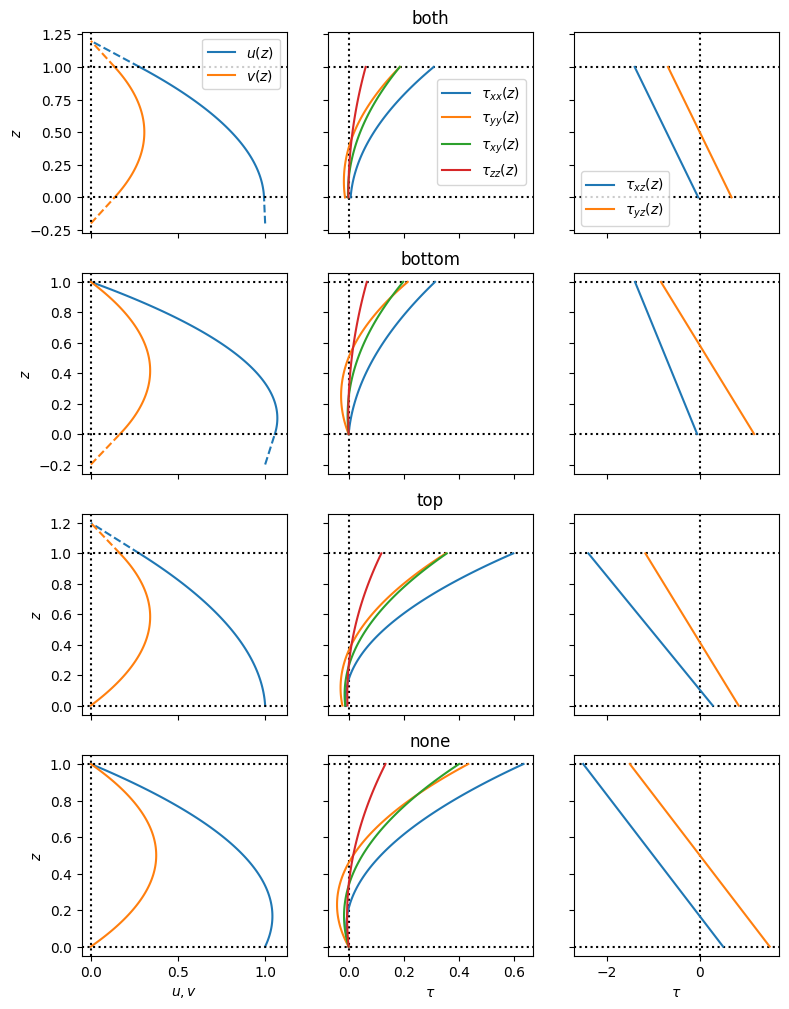

In [15]:
q_test = [1.0, 0.75, 0.25]
dqx_test = [0.0, 0.0, 0.0]
dqy_test = [0.0, 0.0, 0.0]
h_test = [1.0, 0.1, 0.1]
z_test = np.linspace(0.0, h_test[0], 100)

Ls = 0.2
U = 1.0
V = 0.0

fig, axes = plt.subplots(4, 3, sharey="row", sharex="col", figsize=(9, 12))

for i, mode in enumerate(["both", "bottom", "top", "none"]):

    ax = axes[i]

    u_test, v_test = get_velocity_profiles(
        z_test, h_test, q_test, Ls=Ls, U=U, V=V, mode=mode
    )
    tau_xx, tau_yy, tau_zz, tau_yz, tau_xz, tau_xy = get_stress_profiles(
        z_test, h_test, q_test, dqx_test, dqy_test, Ls=Ls, mode=mode
    )

    ax[0].plot(u_test, z_test, label=r"$u(z)$")
    ax[0].plot(v_test, z_test, label=r"$v(z)$")

    if mode in ["both", "top"]:
        ax[0].plot(
            [u_test[-1], 0], [h_test[0], h_test[0] + Ls], "--", color="C0"
        )
        ax[0].plot(
            [v_test[-1], 0], [h_test[0], h_test[0] + Ls], "--", color="C1"
        )
    if mode in ["both", "bottom"]:
        ax[0].plot([U, u_test[0]], [-Ls, 0], "--", color="C0")
        ax[0].plot([V, v_test[0]], [-Ls, 0], "--", color="C1")

    for a in ax:
        a.axhline(0.0, ls=":", color="0.0")
        a.axhline(h_test[0], ls=":", color="0.0")
        a.axvline(0.0, ls=":", color="0.0")

    ax[0].set_ylabel(r"$z$")

    ax[1].plot(tau_xx, z_test, label=r"$\tau_{xx}(z)$")
    ax[1].plot(tau_yy, z_test, label=r"$\tau_{yy}(z)$")
    ax[1].plot(tau_xy, z_test, label=r"$\tau_{xy}(z)$")
    ax[1].plot(tau_zz, z_test, label=r"$\tau_{zz}(z)$")

    ax[2].plot(tau_xz, z_test, label=r"$\tau_{xz}(z)$")
    ax[2].plot(tau_yz, z_test, label=r"$\tau_{yz}(z)$")

    if i == 0:
        ax[0].legend()
        ax[1].legend()
        ax[2].legend()

    ax[1].set_title(mode)

ax[0].set_xlabel(r"$u, v$")
ax[1].set_xlabel(r"$\tau$")
ax[2].set_xlabel(r"$\tau$")

plt.show()

See also: [Holey, H. et al. (2022) Tribology Letters, 70(2), p. 36.](https://doi.org/10.1007/s11249-022-01576-5)